In [1]:
import numpy as np
import os
import random
from sys import platform as sys_pf
import matplotlib
if sys_pf == 'darwin':
	matplotlib.use("TkAgg")
from matplotlib import pyplot as plt

import keras
from keras.models import Sequential, Model
from keras.layers import Flatten, Conv2D, MaxPooling2D, Dense, Concatenate, Dot, Lambda, Input
from tensorflow.keras import initializers
from tensorflow.keras.regularizers import l2
from keras.optimizers import Adam
from keras import backend as K

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


Some utility functions 

In [2]:
def load_img(fn):
	I = plt.imread(fn)
	I = np.array(I)
	return I
# convert to str and add leading zero to single digit numbers
def num2str(idx):
	if idx < 10:
		return '0'+str(idx)
	return str(idx)

Practise loading a random image from our dataset

generating figure 1 of 1


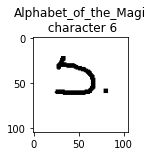

In [3]:
num_alphabets = 1
num_samples = 1
img_dir = r'C:\Users\Admin\few_shot_learning\keras-one-shot\images_background'
alphabet_names = [a for a in os.listdir(img_dir) if a[0] != '.'] # get folder names

for a in range(num_alphabets): # for each alphabet
        print('generating figure ' + str(a+1) + ' of ' + str(num_alphabets))
        alpha_name = alphabet_names[a]
        
        # choose a random character from the alphabet
        character_id = random.randint(1,len(os.listdir(os.path.join(img_dir,alpha_name))))

        # get image directory for this character
        img_char_dir = os.path.join(img_dir,alpha_name,'character'+num2str(character_id))


        # get base file name for this character
        fn_example = os.listdir(img_char_dir)[0]
        fn_base = fn_example[:fn_example.find('_')] 

        plt.figure(a,figsize=(10,8))
        plt.clf()
        for r in range(1,num_samples+1): # for each rendition
            plt.subplot(4,5,r)
            fn_img = img_char_dir + '/' + fn_base + '_' + num2str(r) + '.png'			
            I = load_img(fn_img)
            np.set_printoptions(threshold=np.inf)
            plt.imshow(I, cmap='gray')
            if r==1:
                plt.title(alpha_name[:20] + '\n character ' + str(character_id))


more utility functions to load pixel data for each image in an alphabet and make pairs of images for training

In [4]:
def load_data(alphabet_names):
    X = np.array([])
    Y = np.array([])
    for alpha_name in alphabet_names:
        char_ids = range(1,len(os.listdir(os.path.join(img_dir,alpha_name))) + 1)
        # get image directory for this character
        for char_id in char_ids:
            img_char_dir = os.path.join(img_dir,alpha_name,'character'+num2str(char_id))
            # get list of individual file names for each sample of a character
            img_fns = os.listdir(img_char_dir)
            # np arrays containing data of all samples of a character
            data = np.array([plt.imread(os.path.join(img_char_dir, fn)) for fn in img_fns])
            for i in range(len(img_fns)):
              Y = np.append(Y, alpha_name + '_character'+num2str(char_id)) # within alphabet discrimination
              # Y = np.append(Y, alpha_name) # between alphabet discrimination
            if X.size == 0:
                X = data
            else:
                X = np.vstack((X, data))

        
    return X, Y

def make_pairs(X, Y):

    pairs = []
    labels = []

    for i in range(len(X)):
        # choose a matching sample
        x1 = X[i]
        class_ = Y[i]

        # get possible indices where x2 is same class as x1
        J = [j for j, y in enumerate(Y) if y == class_]
        j = np.random.choice(J)

        x2 = X[j]

        pairs += [[x1, x2]]
        labels += [1]

        # get non-match
        # get possible indices where x2 is different from x1
        J = [j for j, y in enumerate(Y) if y != class_]
        j = np.random.choice(J)

        x2 = X[j]

        pairs += [[x1, x2]]
        labels += [0]
        
    return np.array(pairs), np.array(labels)



Use our utility function to get training set and test set

In [5]:
train_alphabets = alphabet_names[:5] # get first n alphabets (classes)
test_alphabets = alphabet_names[len(alphabet_names)-2:]

X_train, Y_train = load_data(train_alphabets)
X_test, Y_test = load_data(test_alphabets)

train_pairs, train_labels = make_pairs(X_train, Y_train)
train_pairs, train_labels = make_pairs(X_test, Y_test)





We can check if the above worked correctly by showing the image pairs and their corresponding label

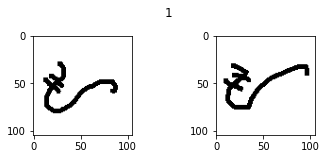

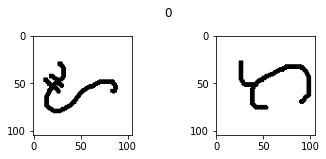

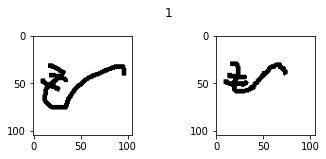

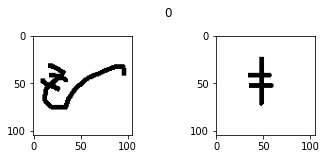

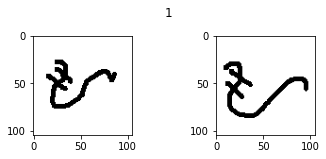

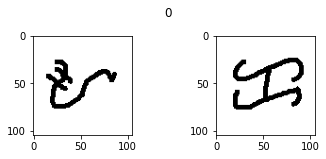

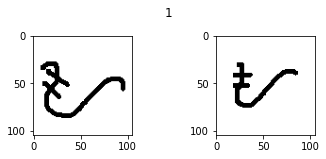

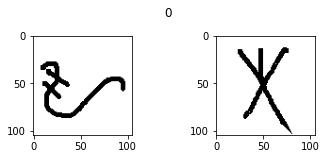

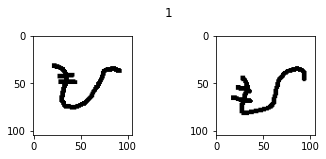

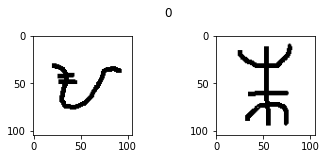

In [25]:
for i in range(10):
    
    fig = plt.figure()
    fig.suptitle(train_labels[i])
    plt.subplot(2,2,1)
    plt.imshow(train_pairs[i][0], cmap='gray')
    plt.subplot(2,2,2)
    plt.imshow(train_pairs[i][1], cmap='gray')

In [7]:
print(train_pairs.shape)

(2880, 2, 105, 105)


Create our model!

In [8]:
def get_siamese_model(input_shape):
    """
        Model architecture
    """

    # Define the tensors for the two input images
    left_input = Input(input_shape)
    right_input = Input(input_shape)

    # Convolutional Neural Network
    model = Sequential()
    # model = Model(Input(input_shape))
    model.add(Conv2D(32, (7,7), activation='relu', input_shape=input_shape,
                    kernel_initializer='random_normal', kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    # model.add(Conv2D(128, (7,7), activation='relu',
    #                     kernel_initializer='random_normal',
    #                     bias_initializer='zeros', kernel_regularizer=l2(2e-4)))
    # model.add(MaxPooling2D())
    # model.add(Conv2D(128, (4,4), activation='relu', kernel_initializer='random_normal',
    #                     bias_initializer='zeros', kernel_regularizer=l2(2e-4)))
    # model.add(MaxPooling2D())
    # model.add(Conv2D(256, (4,4), activation='relu', kernel_initializer='random_normal',
    #                     bias_initializer='zeros', kernel_regularizer=l2(2e-4)))
    model.add(Flatten())
    model.add(Dense(1024, activation='sigmoid',
                    kernel_regularizer=l2(1e-3),
                    kernel_initializer='random_normal',bias_initializer='zeros'))

    # Generate the encodings (feature vectors) for the two images
    encoded_l = model(left_input)
    encoded_r = model(right_input)

    # Add a customized layer to compute the absolute difference between the encodings
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])

    # Add a dense layer with a sigmoid unit to generate the similarity score
    prediction = Dense(1,activation='sigmoid',bias_initializer='zeros')(L1_distance)

    # Connect the inputs with the outputs
    siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)

    # return the model
    return siamese_net

In [9]:
model = get_siamese_model((105,105,1))
model.compile(loss = "binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 105, 105, 1) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 105, 105, 1) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 1024)         78678592    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1024)         0           sequential[0][0]             

train our model!

In [10]:
model.fit([train_pairs[:,0], train_pairs[:,1]], train_labels[:], batch_size=16, epochs=1)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmpagkg1rpr.py, line 48)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmpagkg1rpr.py, line 48)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
180/180 [==============================] - 119s 603ms/step - loss: 81.2258 - accuracy: 0.5173


save our model!

In [17]:
model.save('model_1.h5')

or we can load a model!

In [19]:
from keras.models import load_model
fn = 'model_1.h5'
model = load_model(fn)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 105, 105, 1) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 105, 105, 1) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 1024)         78678592    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1024)         0           sequential[0][0]             

make a function to generate a random n-way-k-shot test (including query image and support set) to test our model

In [11]:
def get_test(X_test, Y_test, N, K):
    from sklearn.utils import shuffle
    # get num_tests amount of queries and support sets (n way k shot)
    # final output is a list of lists of tuples. Each inner list is a test containing tuple pairs in the form: [(Q, s1), (Q, s2),..., (Q, sk)]
    # where Q is the query img and s1 to sk are k imgs of the support set
    # second output is a list of targets(answers)
    # init lists of queries and support sets

    support_set = []
    targets= np.zeros(N*K)
    test_classes = list(set(Y_test))
   
    # choose random index
    i = np.random.randint(0, len(X_test))

    # get query img and corresponding label
    query = X_test[i]
    label = Y_test[i]
    
    # get K pairs that is same class
    for k in range(K):
        pos_j = [j for j, class_ in enumerate(Y_test) if class_ == label]
        j = np.random.choice(pos_j)

        pair = [query, X_test[j]]
        targets[k] = 1
        support_set.append(pair)

    # get n-1 pair that are of diff class
    test_classes.remove(label)

    support_classes = []
    for n in range(N-1):

        random_class = np.random.choice(test_classes)
        support_classes.append(random_class)        
    
        for k in range(K):
            
            pos_j = [j for j, class_ in enumerate(Y_test) if class_ == random_class]
            j = np.random.choice(pos_j)
            pair = [query, X_test[j]]
            support_set.append(pair)
            
        test_classes.remove(random_class)

   
    # shuffle support set and add to all support sets
    support_set, targets = shuffle(support_set, targets)

    return np.array(support_set), np.array(targets)
    

another function to test our model with our test cases

In [26]:
def test_oneshot(model, X_test, Y_test, num_tests, N, K, s = "val", verbose = 0):
    """Test average N way K shot learning accuracy of a siamese neural net over num_test tasks"""
    n_correct = 0
    
    print("Evaluating model on {} random {} way {} shot learning tasks ... \n".format(num_tests, N, K))
      
    for num in range(num_tests):
        
        support_set, targets = get_test(X_test, Y_test, N, K)

        probs = model.predict([support_set[:,0], support_set[:,1]])
        if verbose:
            print('TEST {}'.format(num + 1))
            print('MODEL GUESSED PAIR {}'.format(np.argmax(probs)+1))

        if np.argmax(probs) ==  np.argmax(targets):
            n_correct+=1
        if verbose:
            if np.argmax(probs) ==  np.argmax(targets):
                print("CORRECT")
            else:
                print("INCORRECT")
            print('\n')
        if verbose:
            for i in range(len(support_set)):
    
                fig = plt.figure()
                ax1 = fig.add_subplot(221)
                ax1.imshow(support_set[i][0], cmap='gray')
                ax2 = fig.add_subplot(222)
                ax2.imshow(support_set[i][1], cmap='gray')
                fig.suptitle('TEST {}, PAIR {}\nmodel: {}, actual: {}'.format(num + 1, i+1, probs[i], targets[i]))

    percent_correct = round((100.0 * n_correct / num_tests), 2)

    print("Got an average of {}% {} way {} shot learning accuracy \n".format(percent_correct, N, K))
    return percent_correct

Test our model! Ensure it works as intended by setting verbose=1 to see relevant data

Evaluating model on 3 random 2 way 2 shot learning tasks ... 

TEST 1
MODEL GUESSED PAIR 1
CORRECT


TEST 2
MODEL GUESSED PAIR 1
CORRECT


TEST 3
MODEL GUESSED PAIR 4
INCORRECT


Got an average of 66.67% 2 way 2 shot learning accuracy 



66.67

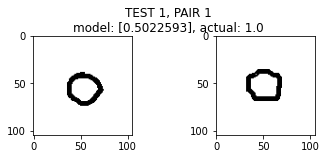

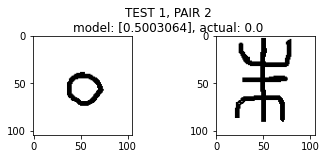

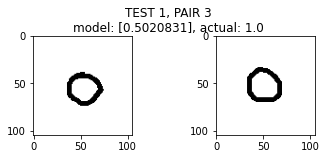

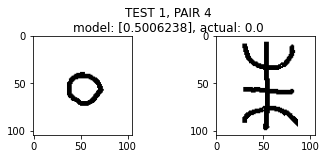

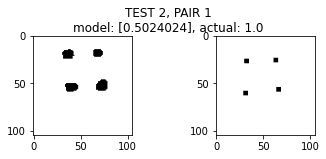

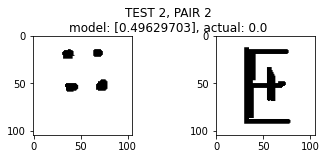

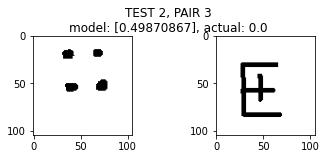

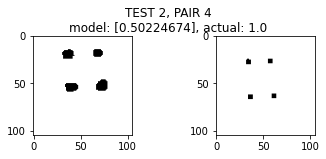

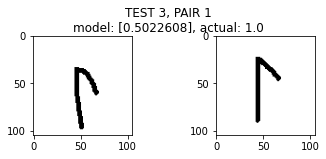

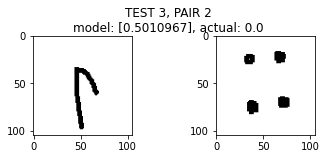

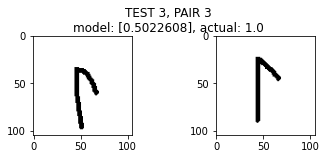

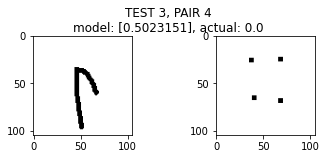

In [27]:
test_oneshot(model, X_test, Y_test, num_tests = 3, N = 2, K = 2, verbose = 1)